In [1]:
from qiskit import QuantumCircuit, Aer, assemble, ClassicalRegister, QuantumRegister, transpile
import numpy as np
from qiskit.visualization import plot_histogram, plot_bloch_multivector


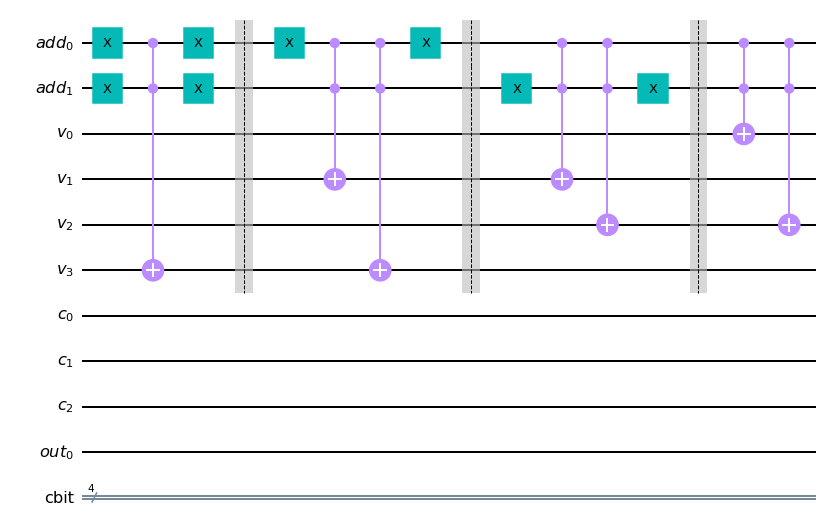

In [2]:
#clause_list = [[0,1], [1,2], [2,3]]
address =  QuantumRegister(2, name='add')
var = QuantumRegister(4, name='v')
clause_qubits = QuantumRegister(3, name='c')
output = QuantumRegister(1, name='out')
result = ClassicalRegister(3, name='cbit')

qc = QuantumCircuit(address, var, clause_qubits, output , result)

def qRAM(qc, address, var):
    qc.x(address)
    qc.mct(address, var[3])
    qc.x(address)
    qc.barrier(address, var)
    
    qc.x(address[0])
    qc.mct(address, var[1])
    qc.mct(address, var[3])
    qc.x(address[0])
    qc.barrier(address, var)

    
    qc.x(address[1])
    qc.mct(address, var[1])
    qc.mct(address, var[2])
    qc.x(address[1])
    qc.barrier(address, var)

    
    qc.mct(address, var[0])
    qc.mct(address, var[2])
    
qRAM(qc, address, var)
qc.draw()

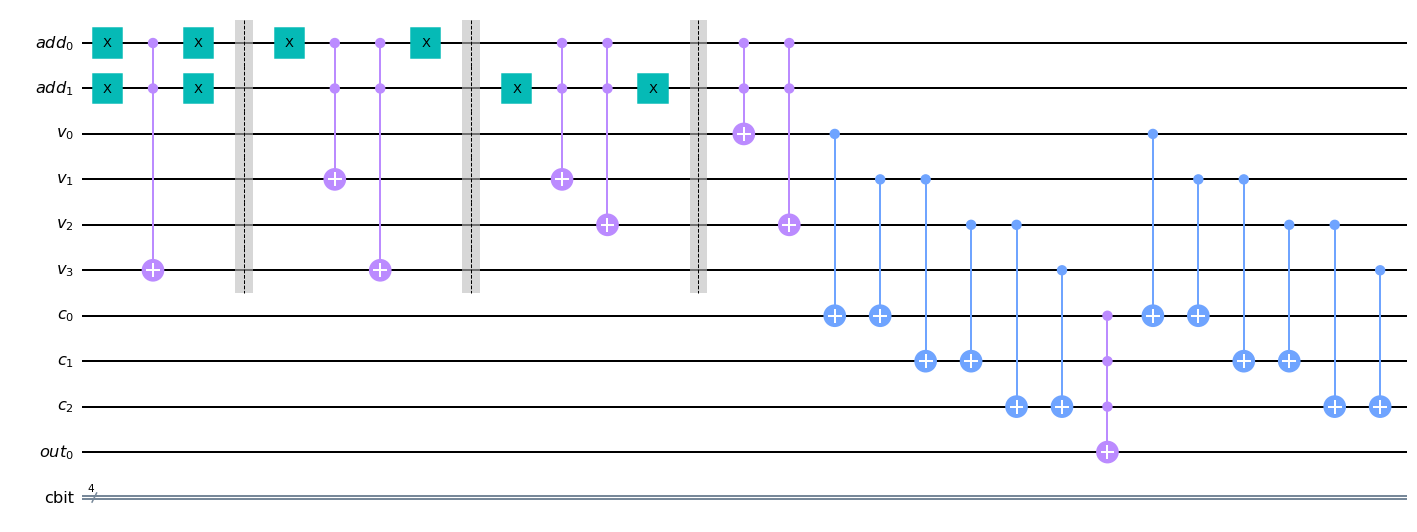

In [3]:
def oracle(qc, var, clause_qubits):
    qc.cx(var[0], clause_qubits[0])
    qc.cx(var[1], clause_qubits[0])

    qc.cx(var[1], clause_qubits[1])
    qc.cx(var[2], clause_qubits[1])
    
    qc.cx(var[2], clause_qubits[2])
    qc.cx(var[3], clause_qubits[2])
    
    qc.mct(clause_qubits, output)
    
    qc.cx(var[0], clause_qubits[0])
    qc.cx(var[1], clause_qubits[0])

    qc.cx(var[1], clause_qubits[1])
    qc.cx(var[2], clause_qubits[1])
    
    qc.cx(var[2], clause_qubits[2])
    qc.cx(var[3], clause_qubits[2])
oracle(qc, var, clause_qubits)
qc.draw(fold=-1)

In [4]:
def diffuser(nqubits):
    qc = QuantumCircuit(nqubits)
    # Apply transformation |s> -> |00..0> (H-gates)
    for qubit in range(nqubits):
        qc.h(qubit)
    # Apply transformation |00..0> -> |11..1> (X-gates)
    for qubit in range(nqubits):
        qc.x(qubit)
    # Do multi-controlled-Z gate
    qc.h(nqubits-1)
    qc.mct(list(range(nqubits-1)), nqubits-1)  # multi-controlled-toffoli
    qc.h(nqubits-1)
    # Apply transformation |11..1> -> |00..0>
    for qubit in range(nqubits):
        qc.x(qubit)
    # Apply transformation |00..0> -> |s>
    for qubit in range(nqubits):
        qc.h(qubit)
    # We will return the diffuser as a gate
    U_s = qc.to_gate()
    U_s.name = "U$_s$"
    return U_s

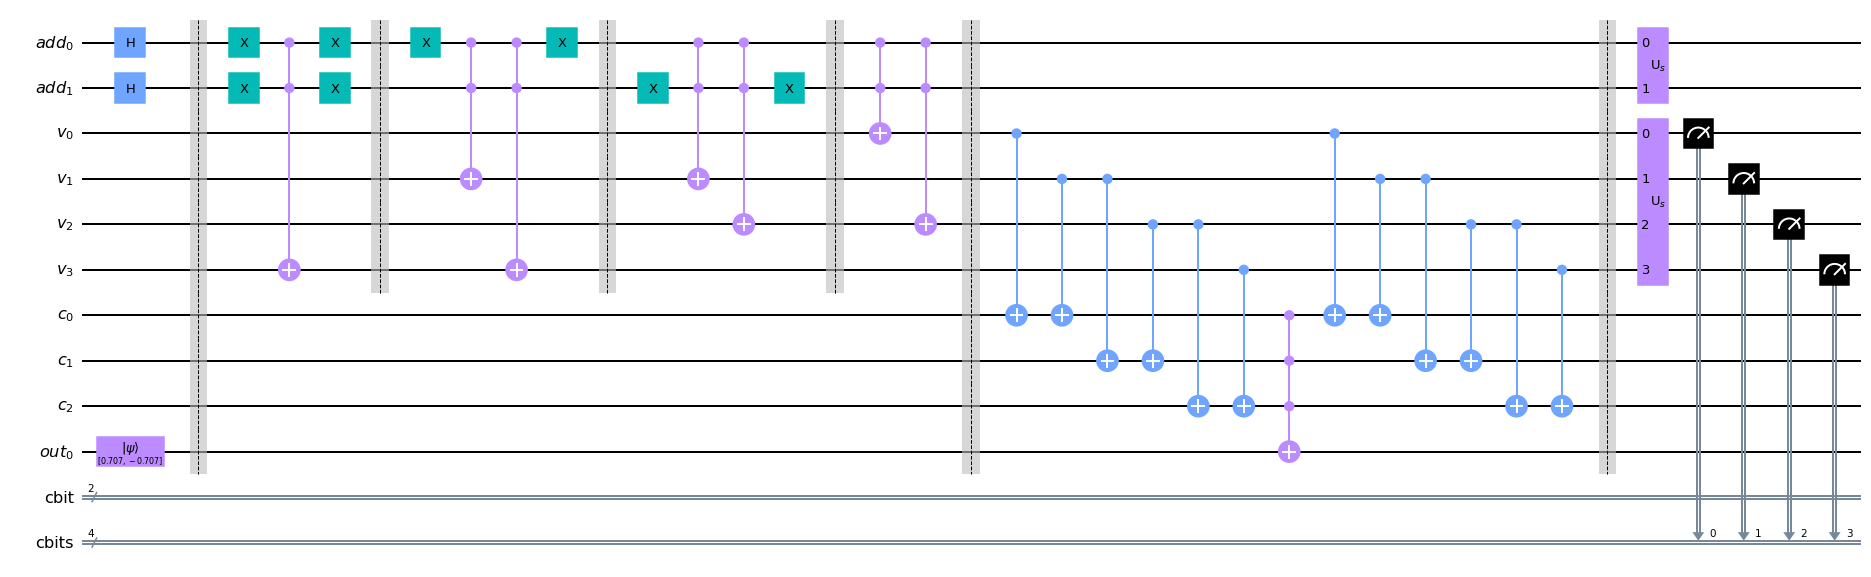

In [24]:
address =  QuantumRegister(2, name='add')
var = QuantumRegister(4, name='v')
clause_qubits = QuantumRegister(3, name='c')
output = QuantumRegister(1, name='out')
result = ClassicalRegister(2, name='cbit')
results = ClassicalRegister(4, name='cbits')

qc = QuantumCircuit(address, var, clause_qubits, output , result, results)

qc.initialize([1, -1]/np.sqrt(2), output)

qc.h(address)
qc.barrier()
qRAM(qc, address, var)
qc.barrier()
#qc.h(var)#remove#
oracle(qc, var, clause_qubits)
qc.barrier()

qc.append(diffuser(2), [0,1])
qc.append(diffuser(4), [2,3,4,5])

#qc.measure(address, result[0:2])
qc.measure(var, results)
qc.draw(fold=-1)

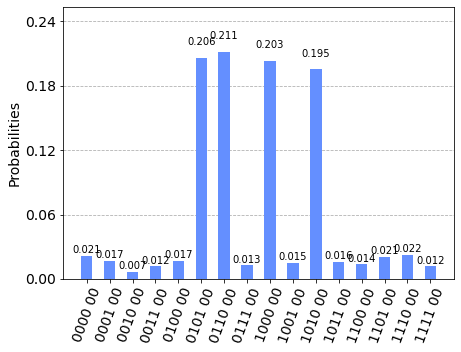

In [25]:
aer_simulator = Aer.get_backend('aer_simulator')
transpiled_qc = transpile(qc, aer_simulator)
qobj = assemble(transpiled_qc)
result = aer_simulator.run(qobj).result()
plot_histogram(result.get_counts())